In [4]:
import tensorflow as tf
import numpy as np


import IPython.display as display
import PIL.Image
import matplotlib as mpl
from tensorflow.keras.preprocessing import image

In [5]:
if tf.test.gpu_device_name(): 

    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

else:

    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [6]:
# Normalize an image
def deprocess(img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)

# Display an image
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


# Outline

1. Base Model is Chosen
2. Layers are extracted using get_layer(name).output
3. The Dream model is built off the inputs and outputs of the model
4. Tiled Gradients is fed the Dream model
5. Deep Dream with Octaves is run


In [7]:
## 1. Base Model is Chosen
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [8]:
# 2. Layers are extracted using get_layer(name).output
# Maximize the activations of these layers
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Calculate Loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [9]:
import os, cv2
noise = np.random.randint(0, 255, (500,500,3))
castle = cv2.imread('castle.jpg')
castle = cv2.cvtColor(castle,cv2.COLOR_BGR2RGB)

In [10]:
import matplotlib.pyplot as plt
plt.imshow(castle)
plt.show()

<Figure size 640x480 with 1 Axes>

In [11]:
castle

array([[[131, 190, 206],
        [137, 196, 210],
        [145, 203, 217],
        ...,
        [158, 211, 215],
        [158, 211, 215],
        [158, 211, 215]],

       [[140, 197, 214],
        [145, 203, 217],
        [151, 209, 221],
        ...,
        [158, 211, 215],
        [158, 211, 215],
        [158, 211, 215]],

       [[149, 205, 220],
        [153, 209, 222],
        [158, 214, 227],
        ...,
        [158, 211, 215],
        [158, 211, 215],
        [158, 211, 215]],

       ...,

       [[ 13, 106, 140],
        [ 12, 107, 139],
        [ 12, 106, 140],
        ...,
        [120, 112,  37],
        [118, 112,  36],
        [117, 111,  35]],

       [[  1, 106, 151],
        [  1, 107, 149],
        [  0, 105, 150],
        ...,
        [130, 113,  43],
        [128, 114,  43],
        [127, 115,  43]],

       [[  0, 107, 155],
        [  0, 106, 154],
        [  0, 104, 153],
        ...,
        [128, 109,  40],
        [129, 110,  42],
        [130, 113,  44]]

In [12]:
tf.expand_dims(castle, axis = 0) ## batch size of 1

<tf.Tensor: shape=(1, 720, 1280, 3), dtype=uint8, numpy=
array([[[[131, 190, 206],
         [137, 196, 210],
         [145, 203, 217],
         ...,
         [158, 211, 215],
         [158, 211, 215],
         [158, 211, 215]],

        [[140, 197, 214],
         [145, 203, 217],
         [151, 209, 221],
         ...,
         [158, 211, 215],
         [158, 211, 215],
         [158, 211, 215]],

        [[149, 205, 220],
         [153, 209, 222],
         [158, 214, 227],
         ...,
         [158, 211, 215],
         [158, 211, 215],
         [158, 211, 215]],

        ...,

        [[ 13, 106, 140],
         [ 12, 107, 139],
         [ 12, 106, 140],
         ...,
         [120, 112,  37],
         [118, 112,  36],
         [117, 111,  35]],

        [[  1, 106, 151],
         [  1, 107, 149],
         [  0, 105, 150],
         ...,
         [130, 113,  43],
         [128, 114,  43],
         [127, 115,  43]],

        [[  0, 107, 155],
         [  0, 106, 154],
         [  0, 10

## Reducing Noise

I added total variation to the loss function to remove noise.

In [77]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis = 0) ## converts np array of image to a tensor of the image
    layer_activations = model(img_batch)      ## feed image into model
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    
    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        loss = loss - 0.00001*tf.reduce_sum(tf.image.total_variation(img_batch))
        print(tf.reduce_sum(tf.image.total_variation(img_batch)))
        losses.append(loss)
    
    return tf.reduce_sum(losses)

In [78]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

  #  @tf.function(
   #     input_signature=(
  #          tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
   #         tf.TensorSpec(shape=[], dtype=tf.int32),
   #         tf.TensorSpec(shape=[], dtype=tf.float32),)
  #                )
    
    def __call__(self, img, steps, step_size):
        print("Tracing")

        loss = tf.constant(0.0)
        
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
              # This needs gradients relative to `img`
              # `GradientTape` only watches `tf.Variable`s by default
                tape.watch(img)
                loss = calc_loss(img, self.model)

            # Calculate the gradient of the loss with respect to the pixels of the input image.
            gradients = tape.gradient(loss, img)

            # Normalize the gradients.
            gradients /= tf.math.reduce_std(gradients) + 1e-8 

            # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
            # You can update the image by directly adding the gradients (because they're the same shape!)
            img = img + gradients*step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [79]:
deepdream = DeepDream(dream_model)

In [80]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Step {}, loss {}".format(step, loss))


    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

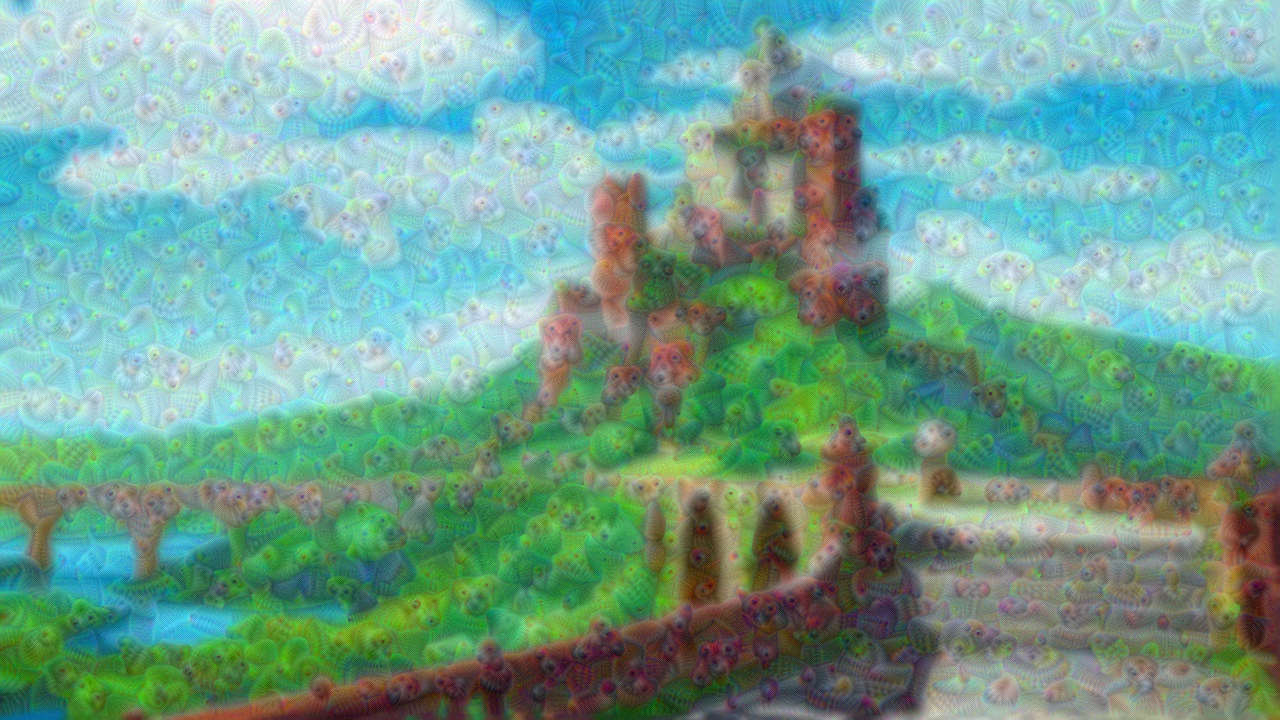

In [89]:
dream_img = run_deep_dream_simple(img=castle, 
                                  steps=100, step_size=0.1)

In [82]:
dream_img[1].numpy().shape

(500, 3)